# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
# for Rotation only cutting the picture
import argparse
import pydash
import random
import imutils as im
import csv
import sqlite3
import tensorflow as tf
import gzip
import struct
import os

from mlxtend.data import loadlocal_mnist

## Parameters

In [2]:
imagePath = "./Briefe/mo_1.jpg"
# Kernel
blurring = 0
dilateErode = 1
dilateKernel = np.ones((dilateErode,dilateErode), "uint8")
erodeKernel = np.ones((dilateErode,dilateErode), "uint8")
# CharacterKernel
characterDilateErode = 5
characterDK = np.ones((characterDilateErode,characterDilateErode),"uint8")
characterEK = np.ones((characterDilateErode,characterDilateErode),"uint8")

 
# C5/6 Scale  220x110
C_5_6_Metrics= [220,110]
C_5_6_Scale = [1.8,2.4]
stampZone = [74,40]
margin = 15
stampMinSize=[28,15]

## Vorbereitung des Bildes

<img src="./README_pictures/Normen_Brief.png"/>

Text(0.5, 1.0, 'Original')

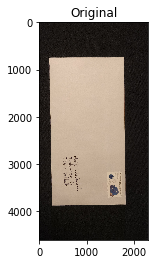

In [3]:
    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
if image is None:
      raise SystemExit("Imagepath is not right")
height,width,channels = image.shape
height-=1
width-=1
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
plt.imshow(showImage)
plt.title("Original")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

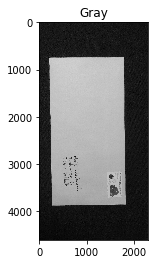

In [4]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

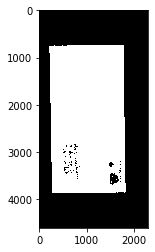

In [5]:
th,binImg  = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
plt.imshow(binImg,cmap="gray")

Text(0.5, 1.0, 'dilate')

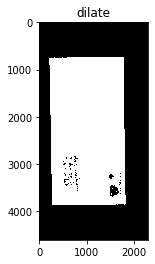

In [6]:
erode = cv2.erode(binImg,erodeKernel,iterations=1)
plt.imshow(erode, cmap="gray")
plt.title("dilate")

Text(0.5, 1.0, 'erode')

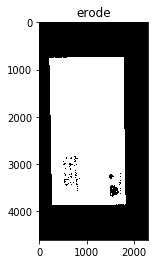

In [7]:
dilate = cv2.dilate(erode,dilateKernel,iterations=1)
plt.imshow(dilate, cmap="gray")
plt.title("erode")

Text(0.5, 1.0, 'Canny')

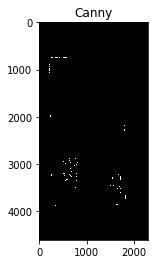

In [8]:
canny = cv2.Canny(dilate,0,30)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

In [9]:
def align_straight(cannyImg):
        img,contours,hierachies = cv2.findContours(cannyImg,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        rotAngle = 0
        for i,contour in enumerate(contours):
            hNext, hPrev, hChild, hParent = hierachies[0][i]
            minArea = cv2.minAreaRect(contour)
            contWidth = minArea[1][0]
            contHeight = minArea[1][1]
            contAngle = minArea[2]       
            #print(contHeight, contWidth, contAngle)\n",
    
            if (contWidth<contHeight):
                height = contWidth
                width = contHeight
                rotAngle = 90
            else:
                height = contHeight
                width = contWidth
                rotAngle = 0
            
            if(height==0) or (width==0):
                scale = -1
                fillFactor = -1
            else:
                scale = width/height
                area_rect = height*width
                letter_rect = cv2.contourArea(contour)
                fillFactor = letter_rect/area_rect
                #print(\"Contour: \",i, \" / scale: \",scale,\" / width: \",width, \" / height:\",height,\"/ Fill:\",fillFactor)
            if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]) and (hChild != -1) and (hParent == -1) and (fillFactor > 0.95):
                #print(\"ALL CRITERIA TRUE: Contour: \",i, \" / scale: \",scale,\" / width: \",width, \" / height:\",height,\"/ Fill:\",fillFactor)
                rotAngle -= contAngle
                return im.rotate_bound(cannyImg,rotAngle), rotAngle

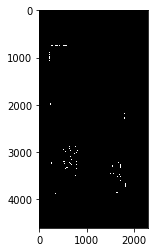

In [10]:
plt.imshow(canny,cmap="gray")

Text(0.5, 1.0, 'straight-aligned')

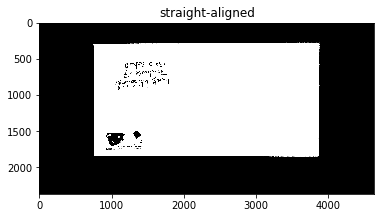

In [11]:
[aligned_image,letterAngle] = align_straight(dilate)
plt.imshow(aligned_image,cmap="gray")
plt.title("straight-aligned")

In [12]:
img,contours,hierachy = cv2.findContours(aligned_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [13]:
def sizeSort(element):
    return len(element)
contours.sort(reverse=True,key=sizeSort)
# Print the 5 biggest Contoursizes
for index,contour in enumerate(contours):
    if(index<6):
        print(contour.size)

19558
3738
1588
1586
1512
1244


## Get the Moments
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [14]:
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def findLetter(img):
        img,contours,hierachies = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
        letter ={} 
        for i,contour in enumerate(contours): 
            hNext, hPrev, hChild, hParent = hierachies[0][i] 
            minArea = cv2.minAreaRect(contour) 
             
            rectWidth = minArea[1][0] 
            rectHeight = minArea[1][1] 
            if (rectHeight<rectWidth): 
                height = rectHeight 
                width = rectWidth 
            else: 
                height = rectWidth 
                width = rectHeight 
             
            if(height==0 or width==0): 
                scale = -1 
                fillFactor = -1 
            else: 
                scale = width/height 
                area_rect = height*width 
                letter_rect = cv2.contourArea(contour) 
                fillFactor = letter_rect/area_rect 
                 
            if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]) and (hChild != -1) and (hParent == -1) and (fillFactor > 0.95): 
                #print(\"Contour: \",i, \" / scale: \",scale,\" / width: \",width, \" / height:\",height,\"/ Fill:\",fillFactor) 
                letter = { 
                    "width": int(width), 
                    "height" : int(height), 
                    "centerX" : int(minArea[0][0]), 
                    "centerY" : int(minArea[0][1]), 
                    "contour": contour 
                    } 
                return letter

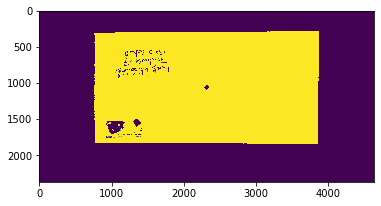

In [15]:
letterValue = findLetter(aligned_image)
if letterValue is None:
      raise SystemExit("letter not found")
# Highlight the Contour of Find Letter and show center of Letter
highlightedContour = aligned_image.copy()
highlightedContour = cv2.circle(highlightedContour,(letterValue["centerX"],letterValue["centerY"]),radius=30, color=(0,0,255),thickness=-1)
cv2.drawContours(highlightedContour, letterValue["contour"], -1, (0, 0, 255), 20) 
plt.imshow(highlightedContour)

## ROI of Letter

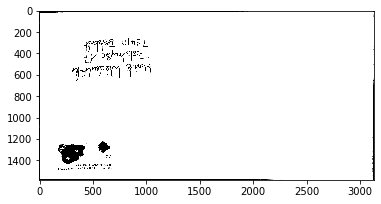

In [16]:
xStart = int(letterValue["centerX"]-letterValue["width"]/2)
xEnd = int(letterValue["centerX"]+letterValue["width"]/2)
yStart = int(letterValue["centerY"]-letterValue["height"]/2)
yEnd = int(letterValue["centerY"]+letterValue["height"]/2)
letter =aligned_image[yStart:yEnd,xStart:xEnd]
plt.imshow(letter, cmap="gray")

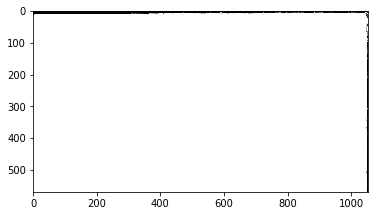

In [17]:
pixelPerMM = letterValue["width"]/C_5_6_Metrics[0]
# StampZone [width, height] amount of Pixel
stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
# get the rigth Top StampZone
rightTop = letter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
plt.imshow(rightTop, cmap="gray")

### Check if stamp is there

In [18]:
def checkStamp(stampZone, pixelPerMM):  
    imgStamp,cStamp,hStamp = cv2.findContours(stampZone,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    stamp_found = False   
    if (len(cStamp)!=0):                #No contour found  
        for index,contour in enumerate(cStamp):           
            #( center (x,y), (width, height), angle of rotation ).  
            hNext, hPrev, hChild, hParent = hStamp[0][index]  
            approx = cv2.approxPolyDP(contour,10,True)  
            minArea = cv2.minAreaRect(approx)  
            #print(minArea)  
            width = minArea[1][0]  
            height = minArea[1][1]                
            if (hChild != -1) and (hParent == -1):      #Extract Parent contour  
                # stamp minSize 22x28  
                contourWidth = width/pixelPerMM  
                contourHeigth = height/pixelPerMM  
                #print(contourHeigth, contourWidth)  
                if((contourWidth >= stampMinSize[0]) and (contourHeigth >= stampMinSize[1])):  
                    stamp_found = True  
                else:  
                    stamp_found = False  
    return stamp_found  
       
def align_correct(roiLetter,pixelPerMM):
    height,width = roiLetter.shape
    # StampZone [width, height] amount of Pixel
    stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
    # get the rigth Top StampZone
    offset = 20
    rightTop = roiLetter[0+offset:stampZoneMetrics[1]-offset,width-stampZoneMetrics[0]+offset:width-offset]
    stamp_found = checkStamp(rightTop,pixelPerMM) 
    if stamp_found:
        return roiLetter,0, stamp_found
    else:
        return im.rotate_bound(roiLetter,180),180, stamp_found


In [19]:
def extractLetter(image): 
    #Preprocessing 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    th,binImg  = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY) 
    erode = cv2.erode(binImg,erodeKernel,iterations=1) 
    dilate = cv2.dilate(erode,dilateKernel,iterations=1)  
    #Not needed! canny = cv2.Canny(dilate,0,30) 
      
    #Rotate image wide side down 
    aligned_image,letterAngle = align_straight(dilate) 
    height, width = aligned_image.shape[:2] 
      
    #Extract ROI of letter and calculate pixel Size 
    letterValue = findLetter(aligned_image) 
    if letterValue is None: 
        raise SystemExit("letter not found") 
    xStart = int(letterValue["centerX"]-letterValue["width"]/2) 
    xEnd = int(letterValue["centerX"]+letterValue["width"]/2) 
    yStart = int(letterValue["centerY"]-letterValue["height"]/2) 
    yEnd = int(letterValue["centerY"]+letterValue["height"]/2) 
    letter = aligned_image[yStart:yEnd,xStart:xEnd] 
    pixelPerMM = letterValue["width"]/C_5_6_Metrics[0] 
      
    #Align images with stamp in the upper right corner 
    correct_aligned,turnAngle,found = align_correct(letter, pixelPerMM) 
      
    #Calculate turning angle and return extracted Letter 
    letterAngle = (letterAngle + turnAngle)%360 
      
    if found: 
        extracted = im.rotate_bound(gray,letterAngle)[yStart:yEnd,xStart:xEnd] 
    else: 
        extracted = im.rotate_bound(gray,letterAngle)[height-yEnd:height-yStart,width-xEnd:width-xStart] 
      
    return extracted, letterAngle, pixelPerMM 

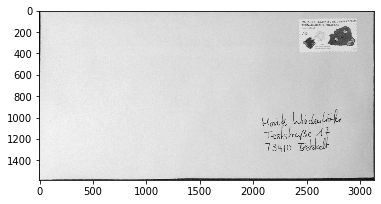

In [20]:
letterGray, letterAngle, pixelPerMM = extractLetter(image)
plt.imshow(letterGray,cmap="gray")

## Get AddressField

Text(0.5, 1.0, 'addressfield')

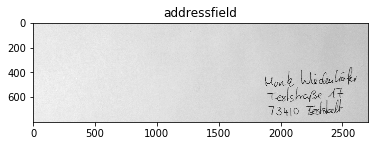

In [21]:
height, width = letterGray.shape
pixelMargin = margin*pixelPerMM
startX = int(pixelMargin)
endX = int(width-pixelMargin)
startY = int(stampZone[1]*pixelPerMM)
endY = int(height-pixelMargin)
addressField = letterGray[startY:endY, startX:endX]
[heightAF, widthAF] = addressField.shape
plt.imshow(addressField, cmap="gray")
plt.title("addressfield")

In [22]:
def getBlurValue(height, blurScale):
    scale = int(height / blurScale)
    if scale % 2 == 0:
        scale += 1
    if scale < 3:
        scale = 3
    print("Value of the blur: " + str(scale))
    return scale

Value of the blur: 9


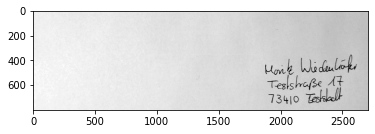

In [23]:
blurrValueAF = getBlurValue(heightAF, 97)
blurrAFKernel = (blurrValueAF, blurrValueAF)
blurrAF = cv2.blur(addressField, blurrAFKernel)
plt.imshow(blurrAF, cmap="gray")

In [24]:
def getClassBorder(grayImage, area=[0, 255]):
    flattenArray = grayImage.flatten()
    filtered = pydash.filter_(
        flattenArray, lambda x: x > area[0] and x < area[1])
    amount, binEdges, _ = plt.hist(filtered, bins=9)
    maxBeginEdge = binEdges[np.where(amount == amount.max())]
    print("area: " + str(area))
    print("amount of pixels: " + str(len(flattenArray)))
    print("Begin of Edge of the max Grayscale Histogram: " + str(maxBeginEdge))
    binEgde = int(maxBeginEdge - 2)
    return binEgde

area: [50, 200]
amount of pixels: 2164800
Begin of Edge of the max Grayscale Histogram: [182.55555556]


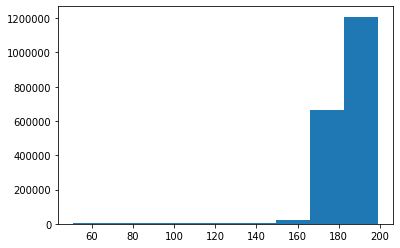

In [25]:
binEdge = getClassBorder(addressField, [50, 200])

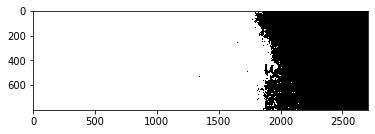

In [26]:
th, binAF = cv2.threshold(blurrAF, binEdge, 255, cv2.THRESH_BINARY)
plt.imshow(binAF, cmap="gray")

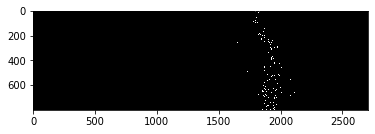

In [27]:
canny = cv2.Canny(binAF, 100, 200)
plt.imshow(canny, cmap="gray")

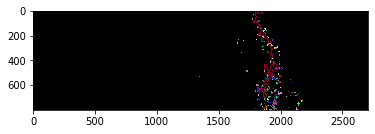

In [28]:
imgAF, contoursAF, hierachyAF = cv2.findContours(
    binAF, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contourImg = np.zeros((heightAF, widthAF, 3))
for index, contour in enumerate(contoursAF):
    r = random.random()
    g = random.random()
    b = random.random()
    cv2.drawContours(contourImg, contoursAF, index, (r, g, b), 5)
plt.imshow(contourImg)

## Display Function
https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

In [29]:
def show_images(images, cols=1, titles=None):
    """Display a list of images in a single figure with matplotlib.

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).

    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Extract the Characters

In [30]:
characters = []
for index, contour in enumerate(contoursAF):
    # [x,y,width,height]
    rect = cv2.boundingRect(contour)
    x = rect[0]
    y = rect[1]
    width = rect[2]
    height = rect[3]
    # 0 because of the outer
    if(width > 5 and height > 5 and width != widthAF and hierachyAF[0][index][3] == 0):
        img = binAF[y:y+height, x:x+width]
        character = {
            "img": img,
            "width": width,
            "height": height,
            "x": x,
            "y": y
        }
        characters.append(character)
        # plt.imshow(character,cmap="gray")
if len(characters) == 0:
    raise SystemExit("No Character with needed size found")
show_images(pydash.map_(characters, "img"))

SystemExit: No Character with needed size found

In [ ]:
centerPoints = characters
print(pydash.map_(characters, ["x"]))
print(pydash.map_(characters, ["y"]))

In [ ]:
mean_width = np.sum(pydash.map_(characters, "width"))/len(characters)
mean_height = np.sum(pydash.map_(characters, "height"))/len(characters)


def sortY(element):
    return element["y"]


centerPoints.sort(key=sortY)
print(mean_width)
print(mean_height)
print(pydash.map_(characters, ["x"]))
print(pydash.map_(characters, ["y"]))

## Get the Rowedges

In [ ]:
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
amount, binEdges, _ = plt.hist(pydash.map_(characters, ["y"]), bins="auto")
rowEdges = []
for i, yValue in enumerate(amount):
    if(yValue > 0):
        rowEdges.append([binEdges[i], binEdges[i+1]])


print(rowEdges)
print(amount)

## Get the Rows

In [ ]:
rows = []
lastChar = characters[len(characters)-1]
for edge in rowEdges:
    rowElements = []
    for index, character in enumerate(characters):
        if(edge[0] <= character["y"]):
            if(edge[1] >= character["y"]):
                rowElements.append(character)
                # for last Edge that the rowElements are added
                if(lastChar == character):
                    rows.append(rowElements)
            else:
                rows.append(rowElements)
                break
print(len(rows))

## Displaying the Rows

In [ ]:
def sortX(element):
    return element["x"]

for row in rows:
    row.sort(key=sortX)
    show_images(pydash.map_(row,"img")) 

## Get PLZ
From Last Row

https://www.sekretaria.de/bueroorganisation/korrespondenz/din-5008/anschrift/

In [ ]:
lastRow = rows[len(rows)-1]
PLZ = lastRow[0:5]
show_images(pydash.map_(PLZ,"img"))

# Neural Network

In [ ]:
dataset_folder = os.path.abspath("./emnist_dataset")
print(dataset_folder)

In [ ]:
class CrvModel:
    def __init__(self, dataset_folder):
        
        # Constants and Paths for Networks
        self.dataset_path = dataset_folder
        self.emnist_classes = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.num_emnist_classes = len(self.emnist_classes)
        self.mnist_classes = "0123456789"
        self.num_mnist_classes = len(self.mnist_classes)
        self.emnist_letter_classes = "-abcdefghijklmnopqrstuvwxyz"
        self.num_emnist_letter_classes = len(self.emnist_letter_classes)
        self.german_digits_classes = "0123456789"
        self.num_german_digits_classes = len(self.german_digits_classes)
        
        # Constants for training and paths to save models
        self.batch_size = 1024
        self.epochs = 200
        self.emnist_save_path = "./emnist_byclass.h5"
        self.emnist_letter_save_path = "./emnist_letter.h5"
        self.mnist_save_path = "./mnist.h5"
        self.german_digit_network_save_path = "./german_digits_network.h5"

        # Read in or download raw data for models
        self.raw_emnist_train_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-train-images-idx3-ubyte.gz'))
        self.raw_emnist_train_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-train-labels-idx1-ubyte.gz'))
        self.raw_emnist_test_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-test-images-idx3-ubyte.gz'))
        self.raw_emnist_test_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-test-labels-idx1-ubyte.gz'))

        self.raw_emnist_letter_train_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-train-images-idx3-ubyte.gz'))
        self.raw_emnist_letter_train_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-train-labels-idx1-ubyte.gz'))
        self.raw_emnist_letter_test_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-test-images-idx3-ubyte.gz'))
        self.raw_emnist_letter_test_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-test-labels-idx1-ubyte.gz'))

        (self.raw_mnist_train_img, self.raw_mnist_train_labels), (self.raw_mnist_test_img, self.raw_mnist_test_labels) = tf.keras.datasets.mnist.load_data()

        self.raw_german_digit_train_img, self.raw_german_digit_train_labels = self.load_german_digits('german_digits_datasets/german_train.data', 'german_digits_datasets/german_train.labels')
        self.raw_german_digit_test_img, self.raw_german_digit_test_labels = self.load_german_digits('german_digits_datasets/german_test.data', 'german_digits_datasets/german_test.labels')

        
        # Preprocess data
        self.emnist_train_img = self.preprocess_data(self.raw_emnist_train_img)
        self.emnist_test_img = self.preprocess_data(self.raw_emnist_test_img)
        self.emnist_train_labels = tf.keras.utils.to_categorical(self.raw_emnist_train_labels)
        self.emnist_test_labels = tf.keras.utils.to_categorical(self.raw_emnist_test_labels)
        
        self.mnist_train_img = self.preprocess_data(self.raw_mnist_train_img)
        self.mnist_test_img = self.preprocess_data(self.raw_mnist_test_img)
        self.mnist_train_labels = tf.keras.utils.to_categorical(self.raw_mnist_train_labels)
        self.mnist_test_labels = tf.keras.utils.to_categorical(self.raw_mnist_test_labels)

        self.emnist_letter_train_img = self.preprocess_data(self.raw_emnist_letter_train_img)
        self.emnist_letter_test_img = self.preprocess_data(self.raw_emnist_letter_test_img)
        self.emnist_letter_train_labels = tf.keras.utils.to_categorical(self.raw_emnist_letter_train_labels)
        self.emnist_letter_test_labels = tf.keras.utils.to_categorical(self.raw_emnist_letter_test_labels)

        self.german_digit_train_img = self.preprocess_data(self.raw_german_digit_train_img)
        self.german_digit_test_img = self.preprocess_data(self.raw_german_digit_test_img)
        self.german_digit_train_labels = tf.keras.utils.to_categorical(self.raw_german_digit_train_labels)
        self.german_digit_test_labels = tf.keras.utils.to_categorical(self.raw_german_digit_test_labels)

        # Earlystopping Callback
        self.early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                    min_delta=0.002,
                                                                    patience=10,
                                                                    verbose = 1,
                                                                    restore_best_weights=True)
                                                                    
        self.german_digits_save_weights_callback = tf.keras.callbacks.ModelCheckpoint(self.german_digit_network_save_path,
                                                        monitor="val_loss",
                                                        verbose=1,
                                                        save_best_only=True,
                                                        save_weights_only=True
                                                    )


        # Setup network architecture
        self.emnist_cnn = self.setup_network(self.num_emnist_classes)
        self.emnist_letter_cnn = self.setup_network(self.num_emnist_letter_classes)
        self.mnist_cnn = self.setup_network(self.num_mnist_classes)
        self.german_digits_network = self.setup_network(self.num_german_digits_classes)


    
    # Function Definitions
    def load_german_digits(self, img_path, labels_path):
        train_img, train_labels = loadlocal_mnist(
            images_path=img_path, 
            labels_path=labels_path)
        train_img = train_img.reshape(train_img.shape[0], 28, 28)
        return train_img, train_labels
        
    def read_local_data(self, path):
        print("Lese Datenset '%s' ein" %path)
        with gzip.open(path, "rb") as f:
            z, dtype, dim = struct.unpack(">HBB", f.read(4))
            print("Dimensions:", dim)
            shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dim))
            print("Shape:", shape)
            print("***********************************************")
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
        
    def show_random_image(self, data_imgs, classes, data_labels):
        i = random.randint(0, data_imgs.shape[0])
        fig, ax = plt.subplots()
        ax.clear()
        ax.imshow(data_imgs[i], cmap="gray")
        title = "label = %d = %s" %(data_labels[i], classes[data_labels[i]])
        ax.set_title(title, fontsize=20)
        plt.show()
        
    def preprocess_data(self, raw_data):
        normalized_data = raw_data.astype("float32")/255
        reshaped_data = normalized_data.reshape(normalized_data.shape[0], 28, 28, 1)
        return reshaped_data

    def setup_network(self, num_classes):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.4))
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        return model
        

## Model initialisieren

In [ ]:
model = CrvModel(dataset_folder)

In [ ]:
model.show_random_image(model.raw_emnist_train_img, model.emnist_classes, model.raw_emnist_train_labels)
model.show_random_image(model.raw_mnist_train_img, model.mnist_classes, model.raw_mnist_train_labels)
model.show_random_image(model.raw_emnist_letter_train_img, model.emnist_letter_classes, model.raw_emnist_letter_train_labels)
model.show_random_image(model.raw_german_digit_train_img, model.german_digits_classes, model.raw_german_digit_train_labels)

In [ ]:
print("-----------------------------------------------------------------------------")
print("Full Emnist Neural Network")

model.emnist_cnn.summary()
model.emnist_cnn.compile(loss = "categorical_crossentropy",
                         optimizer = "adam",
                         metrics = ["accuracy"],
                         callbacks = [model.early_stopping_callback])

print("-----------------------------------------------------------------------------")
print("Emnist Letter Neural Network")
model.emnist_letter_cnn.summary()
model.emnist_letter_cnn.compile(loss = "categorical_crossentropy",
                         optimizer = "adam",
                         metrics = ["accuracy"],
                         callbacks = [model.early_stopping_callback])

print("-----------------------------------------------------------------------------")
print("Mnist Neural Network")
model.mnist_cnn.summary()
model.mnist_cnn.compile(loss = "categorical_crossentropy", 
                        optimizer = "adam",
                        metrics = ["accuracy"])

print("-----------------------------------------------------------------------------")
print("German Digits Network")
model.german_digits_network.summary()
model.german_digits_network.compile(loss = "categorical_crossentropy", 
                        optimizer = "adam",
                        metrics = ["accuracy"])

In [ ]:
'''                                                                                              
print("*******************************************************************")
print("Train Emnist Model")
print("*******************************************************************")

model.emnist_trained = model.emnist_cnn.fit(model.emnist_train_img,
              model.emnist_train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.emnist_test_img, model.emnist_test_labels),
              callbacks = [model.early_stopping_callback])

model.emnist_cnn.save(model.emnist_save_path)

print("*******************************************************************")
print("Train Emnist Letter Model")
print("*******************************************************************")

model.emnist_letter_trained = model.emnist_letter_cnn.fit(model.emnist_letter_train_img,
              model.emnist_letter_train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.emnist_letter_test_img, model.emnist_letter_test_labels),
              callbacks = [model.early_stopping_callback])

model.emnist_letter_cnn.save(model.emnist_letter_save_path)


print("*******************************************************************")
print("Train Mnist Letter Model")
print("*******************************************************************")

model.mnist_trained = model.mnist_cnn.fit(model.mnist_train_img,
                                    model.mnist_train_labels,
                                    batch_size = model.batch_size,
                                    epochs = model.epochs,
                                    verbose = 1,
                                    validation_data = (model.mnist_test_img, model.mnist_test_labels),
                                    callbacks = [model.early_stopping_callback])

model.mnist_cnn.save(model.mnist_save_path)


print("*******************************************************************")
print("Train German Digits Model")
print("*******************************************************************")

model.german_digits_trained = model.german_digits_network.fit(model.german_digit_train_img,
                                    model.german_digit_train_labels,
                                    batch_size = model.batch_size,
                                    epochs = model.epochs,
                                    verbose = 1,
                                    validation_data = (model.german_digit_test_img, model.german_digit_test_labels),
                                    callbacks = [model.german_digits_save_weights_callback]
                                )

model.german_digits_network.load_weights(model.german_digit_network_save_path)
'''

In [ ]:
model.emnist_cnn.load_weights(model.emnist_save_path)
model.emnist_letter_cnn.load_weights(model.emnist_letter_save_path)
model.mnist_cnn.load_weights(model.mnist_save_path)
model.german_digits_network.load_weights(model.german_digit_network_save_path)

In [ ]:
def visualize_result(model_name, model_history):
    plt.figure()
    plt.suptitle(model_name, fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(model_history['loss'])
    plt.plot(model_history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(model_history['accuracy'])
    plt.plot(model_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
#visualize_result("Emnist Full Network", model.emnist_trained.history)
#visualize_result("Emnist Letter Network", model.emnist_letter_trained.history)
#visualize_result("Mnist Network", model.mnist_trained.history)
#visualize_result("German Digits Network", model.german_digits_trained.history)

In [ ]:
emnist_results = model.emnist_cnn.evaluate(model.emnist_test_img, model.emnist_test_labels, verbose=0)
emnist_letter_results = model.emnist_letter_cnn.evaluate(model.emnist_letter_test_img, model.emnist_letter_test_labels, verbose=0)
mnist_results = model.mnist_cnn.evaluate(model.mnist_test_img, model.mnist_test_labels, verbose=0)
german_digits_results = model.german_digits_network.evaluate(model.german_digit_test_img, model.german_digit_test_labels, verbose=0)

print('Emnist Loss: %.2f%%, Accuracy: %.2f%%' % (emnist_results[0]*100, emnist_results[1]*100))
print('Emnist Letter Loss: %.2f%%, Accuracy: %.2f%%' % (emnist_letter_results[0]*100, emnist_letter_results[1]*100))
print('Mnist Loss: %.2f%%, Accuracy: %.2f%%' % (mnist_results[0]*100, mnist_results[1]*100))
print('German Digits Loss: %.2f%%, Accuracy: %.2f%%' % (german_digits_results[0]*100, german_digits_results[1]*100))

In [ ]:
def preprocess_segmented_image(img):
    img = ~img
    img = img.astype("float32")/255
    s = max(img.shape[0:2])
    f = np.zeros((s, s))
    ax, ay = (s - img.shape[1])//2, (s - img.shape[0])//2
    f[ay:img.shape[0]+ay, ax:ax+img.shape[1]] = img
    img = cv2.resize(img, (28,28))
    return img

In [ ]:
PLZ_array = np.array(pydash.map_(PLZ,"img")[0])
predictionArray = []
for i, img in enumerate(pydash.map_(PLZ, "img")):
    predictionArray.append(preprocess_segmented_image(img))

array = np.array(predictionArray)
array = np.expand_dims(array, axis=3)
print(array.shape)


In [ ]:
predictions = model.german_digits_network.predict(array)

In [ ]:
for prediction in predictions:
    print(np.argmax(prediction))

In [ ]:
model.show_random_image(model.raw_german_digit_train_img, model.german_digits_classes, model.raw_german_digit_train_labels)

# Abgleich mit Datenbank

In [ ]:
# def get_town(plz):
#     # Verbindung, Cursor
#     connection = sqlite3.connect("orteDE.db")
#     cursor = connection.cursor()

#     # SQL-Abfrage
#     sql = "SELECT ortsname, bundesland FROM orte WHERE plz="+str(plz)

#     # Kontrollausgabe der SQL-Abfrage
#     # print(sql) 

#     # Absenden der SQL-Abfrage
#     # Empfang des Ergebnisses
#     cursor.execute(sql)

#     # Ausgabe des Ergebnisses
#     results = cursor.fetchall()
#     #for dsatz in cursor:
#     #    ort = dsatz[0]
#     #    bundesland = dsatz[1]
        
#     # Verbindung beenden
#     connection.close()

#     return results

In [ ]:
# #Example for single PLZ
# print(get_town(74246))
# #Example for multiple PLZ
# print(get_town(27367))